# Evaluate Model Performance
We want to compare the speed of the model to that of TD-DFT

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import time
import os
import re

Things to change

In [2]:
traj_path = os.path.join('..', 'datasets', '256_Al', 'Dv1.0')

## Read in Files
We need the random trajectory data, and the trajectory computer

In [3]:
random_traj = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [4]:
traj_computer = pkl.load(open('traj_computer.pkl', 'rb'))

## Get the performance of TD-DFT
Get the time per iteration of TD-DFT for the random trajectory

In [5]:
random_traj_files = glob(os.path.join(traj_path, 'kp*.out'))
print('Found {} trajectory files'.format(len(random_traj_files)))

Found 6 trajectory files


Make a function to get the CPU time per iteration

In [6]:
cpu_count_re = re.compile('<mpi_processes count="(.*)"')
assert cpu_count_re.findall('<mpi_processes count="256"') == ['256']

In [7]:
timing_re = re.compile('max="(.*)"')
assert timing_re.findall('max="5"') == ["5"]

In [8]:
def get_iteration_cpu_times(file):
    """Get the CPU time per iteration
    
    Args:
        file (str): path to file to be evaluated
    Returns:
        - ([float]) CPU time per iteration
        - (int) number of cpus"""
    
    with open(file) as fp:
        timings = []
        for line in fp:
            if "<mpi_processes" in line:
                cpu_count = int(cpu_count_re.findall(line)[0])
            if 'timing name="iteration"' in line:
                timings += [float(timing_re.findall(line)[0])]
    
    return np.multiply(timings, cpu_count), cpu_count

Make sure it kind of agrees with the total simulation time, which includes the startup cost

In [9]:
timings, cpu_count = get_iteration_cpu_times(os.path.join(traj_path, 'kpgenlong_sd_psd_combo_r17_111_cutoff_50_4.out'))
assert abs(timings.sum() / cpu_count - 17334) / 17334 < 0.10

Get the timings for all steps

In [10]:
%%time
timings = np.hstack([get_iteration_cpu_times(f)[0] for f in random_traj_files])

CPU times: user 2.07 s, sys: 648 ms, total: 2.72 s
Wall time: 2.7 s


In [11]:
print('Mean time: {:.2f} CPU-hours'.format(timings.mean() / 3600))

Mean time: 2.01 CPU-hours


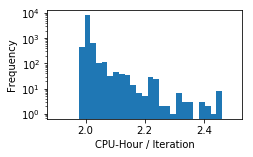

In [12]:
fig, ax = plt.subplots()

ax.hist(timings / 3600, bins=np.linspace(1.9, 2.5, 32))

ax.set_yscale('log')

ax.set_xlabel('CPU-Hour / Iteration')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)

*Finding*: The iterations reliably take around 2 CPU-hours each

### Get the Timing for the Channel
The other trajectory for the test

In [13]:
channel_files = glob(os.path.join(traj_path, '..', '..', 'Al_256_channel', 'kp*.out'))
print('Found {} trajectory files'.format(len(random_traj_files)))

Found 6 trajectory files


In [14]:
%%time
timings = np.hstack([get_iteration_cpu_times(f)[0] for f in channel_files])

CPU times: user 792 ms, sys: 328 ms, total: 1.12 s
Wall time: 1.12 s


In [15]:
print('Total hours: {:.2f} CPU-hours'.format(np.sum(timings) / 3600))

Total hours: 4028.67 CPU-hours


## Time the ML Model
Measure over the same trajectory

In [16]:
%%time
ml_timings = []
for p, v in random_traj[['position', 'velocity']].values:
    start = time.perf_counter()
    X = traj_computer.featurizers.featurize(p, v)
    f = traj_computer.model.predict([X])
    stop = time.perf_counter()
    ml_timings.append(stop - start)

CPU times: user 1min 38s, sys: 16 ms, total: 1min 38s
Wall time: 1min 38s


Compute the average run time

In [17]:
print('Average ML time: {:.2e} CPU-s, {:.3e} CPU-hr'.format(np.mean(ml_timings), np.mean(ml_timings) / 3600))

Average ML time: 1.01e-02 CPU-s, 2.801e-06 CPU-hr


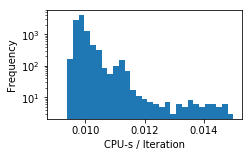

In [18]:
fig, ax = plt.subplots()

ax.hist(ml_timings, bins=np.linspace(0.009, 0.015, 32))

ax.set_yscale('log')

ax.set_xlabel('CPU-s / Iteration')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)

*Finding*: ~0.01 CPU-s per iterations is a good estimate (and this is without pipelining)